<a href="https://colab.research.google.com/github/DomenicoArmillotta/ImageClassification-OCT/blob/main/OCT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cose da fare e/o controllare : 

*  FARE  Test
* provare con le pre trainate : inceptionv3
https://www.tensorflow.org/tutorials/load_data/images?hl=it



[Dataset](https://www.kaggle.com/datasets/paultimothymooney/kermany2018)

# **Library + Class weight**

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Flatten
from tensorflow.python.keras.layers import Dropout
from sklearn.metrics import accuracy_score
np.random.seed(42)
from google.colab import drive

from matplotlib import style
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import cv2
import os
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Input, Activation, add, Add, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.models import Sequential, Model
from keras import optimizers

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input


Distribution of the class inside the folder

In [ ]:
#compute class weight train for inbalanced dataset --> estimated time for 80k documents = 3s

import pathlib

# create array with all classes in the train
summary = pd.DataFrame()
val_classes = [item.name for item in 
                 pathlib.Path('/content/drive/MyDrive/dataset/OCT/train').glob('*')]

# count the number of files in each folder
# print(val_classes)
for d in ['train']:
    for c in val_classes:
        n = len([i for i in pathlib.Path(f'/content/drive/MyDrive/dataset/OCT/{d}/{c}').glob('*')])
        summary.loc[c, d] = n
summary.style.format("{:.0f}")




,train
CNV,37214
DME,11348
DRUSEN,8616
NORMAL,26315


Compue class_weights

In [ ]:
train_directory = '/content/drive/MyDrive/dataset/OCT/train/'

# ['DME', 'CNV', 'NORMAL', '.DS_Store', 'DRUSEN']
from tqdm import tqdm
def get_data(folder):
    """
    Load the data and labels from the given folder.
    """
    X = []
    y = []
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['NORMAL']:
                label = 0
            elif folderName in ['CNV']:
                label = 1
            elif folderName in ['DME']:
                label = 2
            elif folderName in ['DRUSEN']:
                label = 3
            else:
                label = 4
            for image_filename in tqdm(os.listdir(folder + folderName)):
                y.append(label)
    y = np.asarray(y)
    return y
y_train= get_data(train_directory)


from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = 4)

from sklearn.utils import class_weight
class_weight = class_weight.compute_class_weight(class_weight = "balanced", classes = np.unique(y_train),y =  y_train)
class_weights = dict(zip(np.unique(y_train), class_weight))
class_weights


100%|██████████| 26315/26315 [00:00<00:00, 1369869.31it/s]


{0: 0.7932072962188865,
 1: 0.5608977804052239,
 2: 1.839376982728234,
 3: 2.4226149025069637}

# **1. ALEXNET from scratch**

In [ ]:
# setup directory used in the project for training and test phase
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/dataset/OCT/'
train_dir = '/content/drive/MyDrive/dataset/OCT/train'
test_dir = '/content/drive/MyDrive/dataset/OCT/test'
val_dir = '/content/drive/MyDrive/dataset/OCT/val/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='grayscale',
    batch_size=128,
    image_size=(50, 50),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)



val = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='grayscale',
    batch_size=128,
    image_size=(50, 50),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)






In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
val = val.map(lambda x, y: (normalization_layer(x), y))
train = train.map(lambda x, y: (normalization_layer(x), y))


In [ ]:
# mantiene le immagini in memoria dopo che sono state caricate dal disco durante la prima epoca. Velocizza il training
AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [ ]:
img_size = 50
model = keras.models.Sequential()
#1st Convolutional Layer
model.add(keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu', input_shape = [img_size, img_size,1]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Dropout(0.2))
#2nd Convolutional Layer
model.add(keras.layers.Conv2D(filters=64,kernel_size=3,activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Dropout(0.2))
#3rd Convolutional Layer
model.add(keras.layers.Conv2D(filters=128,kernel_size=3,activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Dropout(0.2))
#4th Convolutional Layer
model.add(keras.layers.Conv2D(filters=256,kernel_size=3,activation='relu'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPooling2D(pool_size=2))
model.add(keras.layers.Dropout(0.2))
#Passing it to a Fully Connected layer
model.add(keras.layers.Flatten())

# 1st Fully Connected Layer
model.add(keras.layers.Dense(512,activation='relu'))

# 2st Fully Connected Layer
model.add(keras.layers.Dense(512,activation='relu'))

#Softmax layer for output
model.add(keras.layers.Dense(4,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 22, 22, 64)       2

### Training **Senza** Augmentation

In [ ]:

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

history = model.fit(train, epochs=12, validation_data=val ,steps_per_epoch=150 , verbose = 1 , callbacks=[early_stopping] , class_weight = class_weights)


Epoch 1/12
 68/150 [============>.................] - ETA: 36:44 - loss: 1.3959 - accuracy: 0.6013

KeyboardInterrupt: ignored

In [ ]:
model.save('/content/drive/MyDrive/model/AlexNet_noAUG.h5')   # always save your weights after training or during training
#evaluation with history
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
#disconnessione per non consumare risorse
from google.colab import runtime
runtime.unassign()

### Training **Con** Augmentation

In [ ]:
#Augmentation --> farlo con il layer
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

img_height = 50
batch_size=32
epochs = 20
model.fit(aug.flow_from_directory(directory=train_dir,target_size=(img_height, img_height),batch_size=batch_size ,shuffle=True,color_mode='grayscale',seed=None,class_mode='categorical'),
          epochs=epochs,
          validation_data=val,
          class_weight = class_weights)

In [ ]:
model.save('/content/drive/MyDrive/model/AlexNet_AUG.h5')   # always save your weights after training or during training
#evaluation with history
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
#disconnessione per non consumare risorse
from google.colab import runtime
runtime.unassign()

# **2. MNIST from scratch**

In [ ]:
# setup directory used in the project for training and test phase
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/dataset/OCT/'
train_dir = '/content/drive/MyDrive/dataset/OCT/train'
test_dir = '/content/drive/MyDrive/dataset/OCT/test'
val_dir = '/content/drive/MyDrive/dataset/OCT/val/'

In [ ]:
train = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='grayscale',
    batch_size=128,
    image_size=(50, 50),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)



val = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='grayscale',
    batch_size=128,
    image_size=(50, 50),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)


In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
val = val.map(lambda x, y: (normalization_layer(x), y))
train = train.map(lambda x, y: (normalization_layer(x), y))


In [ ]:
# mantiene le immagini in memoria dopo che sono state caricate dal disco durante la prima epoca. Velocizza il training
AUTOTUNE = tf.data.AUTOTUNE

train = train.cache().prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
#Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [ ]:
#Augmentation --> farlo con il layer
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
#we made the model with the augmentation layer

model = keras.models.Sequential()
model.add(keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu', input_shape = [50, 50,1]))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Conv2D(filters=64 , activation='relu',kernel_size=3))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Conv2D(filters=128 , activation='relu' ,kernel_size=3))
model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(250,activation='relu'))
model.add(keras.layers.Dense(4,activation='softmax'))
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

### Train **senza** augmentation

In [ ]:
#train senza augmentation
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy']
              )

history = model.fit(train, epochs=8, validation_data=val , verbose = 1 , steps_per_epoch=150 ,  class_weight = class_weights)

Epoch 1/8
150/150 [==============================] - 2311s 13s/step - loss: 1.3722 - accuracy: 0.4941 - val_loss: 1.2377 - val_accuracy: 0.5000
Epoch 2/8
150/150 [==============================] - 1883s 13s/step - loss: 1.0494 - accuracy: 0.6640 - val_loss: 0.9739 - val_accuracy: 0.5000
Epoch 3/8
150/150 [==============================] - 2039s 14s/step - loss: 0.9520 - accuracy: 0.6917 - val_loss: 0.8526 - val_accuracy: 0.5625
Epoch 4/8
150/150 [==============================] - 2298s 15s/step - loss: 0.8734 - accuracy: 0.7266 - val_loss: 0.7811 - val_accuracy: 0.6250
Epoch 5/8
 53/150 [=========>....................] - ETA: 16:41 - loss: 0.8313 - accuracy: 0.7469

150/150 [==============================] - 550s 4s/step - loss: 0.8313 - accuracy: 0.7469 - val_loss: 0.7957 - val_accuracy: 0.5938


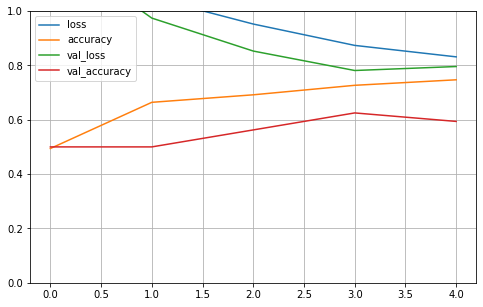

In [ ]:
model.save('/content/drive/MyDrive/dataset/model/MNIST.h5')   # always save your weights after training or during training
#evaluation with history
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
#disconnessione per non consumare risorse
from google.colab import runtime
runtime.unassign()

# **3. EFFICENT NET pre trained**

In [ ]:
# epochs = 20  # @param {type: "slider", min:10, max:100}
#Augmentation --> farlo con il layer

m_channels = 3
train = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb', #--> attenzione a questo valore
    batch_size=64,
    image_size=(150, 150),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

val = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=64,
    image_size=(150, 150),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False
)

aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

img_dim = 150
batch_size=64
train_augmented = aug.flow_from_directory(
    directory=train_dir,
    target_size=(img_dim, img_dim),
    batch_size=batch_size ,
    shuffle=True,
    color_mode='rgb',
    seed=None,
    class_mode='categorical')

Found 83493 files belonging to 4 classes.
Found 32 files belonging to 4 classes.
Found 83493 images belonging to 4 classes.


In [ ]:
# Create Model
img_dim = 150
m_channels = 3
model_ENB0 = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(img_dim,img_dim,m_channels))
model_ENB0.trainable = False
CLASSES = 4
model = Sequential()
model.add(model_ENB0)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(CLASSES,activation="softmax"))
model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_4 (Rescaling)        (None, 150, 150, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 150, 150, 3)  7          ['rescaling_4[0][0]']            
 )                                                                                                
                                                                                     

### **OPTION 1 = Feature Reuse Training**

In [ ]:
#Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)
model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.Adam(learning_rate=1e-2),
              metrics=['accuracy'])

# with augmentation 
# history = model.fit(train_augmented, epochs=5 , validation_data=val , verbose = 1 , callbacks=[early_stopping] , class_weight = class_weights)

# without augmentation 
history = model.fit(train, epochs=15 , validation_data=val ,steps_per_epoch=150, verbose = 1 , callbacks=[early_stopping] , class_weight = class_weights)


Epoch 1/15
150/150 [==============================] - ETA: 0s - loss: 1.2770 - accuracy: 0.5889

150/150 [==============================] - 1797s 9s/step - loss: 1.2770 - accuracy: 0.5889 - val_loss: 1.0849 - val_accuracy: 0.5625
Epoch 2/15
150/150 [==============================] - ETA: 0s - loss: 1.2280 - accuracy: 0.6204

150/150 [==============================] - 1337s 9s/step - loss: 1.2280 - accuracy: 0.6204 - val_loss: 1.1895 - val_accuracy: 0.6875
Epoch 3/15
 76/150 [==============>...............] - ETA: 11:07 - loss: 1.2343 - accuracy: 0.6155

KeyboardInterrupt: ignored

In [ ]:
#evaluation with history
model.save('/content/drive/MyDrive/model/efficent_featurereuse.h5')   # always save your weights after training or during training
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
#disconnessione per non sprecare risorse
from google.colab import runtime
runtime.unassign()

### **OPTION 2 = fine tuning training**

In [ ]:
# Freezing all layers until the fifth from the last
model_ENB0.trainable = True
for layer in model_ENB0.layers[:-5]:
 layer.trainable = False

 
# model_ENB0.summary()

In [ ]:
#Early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

# Pre Training
model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.Adam(learning_rate=1e-2),
              metrics=['accuracy'])
 

# history = model.fit(train_augmented, epochs=5 , validation_data=val , verbose = 1 , callbacks=[early_stopping] , class_weight = class_weights)
history = model.fit(train, epochs=20 ,steps_per_epoch=250, validation_data=val , verbose = 1 , callbacks=[early_stopping] , class_weight = class_weights)

Epoch 1/20
250/250 [==============================] - ETA: 0s - loss: 1.5839 - accuracy: 0.3181

250/250 [==============================] - 1358s 5s/step - loss: 1.5839 - accuracy: 0.3181 - val_loss: 4.8089 - val_accuracy: 0.2500
Epoch 2/20
230/250 [==========================>...] - ETA: 1:45 - loss: 1.5479 - accuracy: 0.3162

In [ ]:
#evaluation with history
model.save('/content/drive/MyDrive/model/efficent_finetuning.h5')   # always save your weights after training or during training
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
#disconnessione per non sprecare risorse
from google.colab import runtime
runtime.unassign()

# **4. INCEPTION V3 pre-trained**

[esempio](https://github.com/tejanirla/image_classification/blob/master/transfer_learning.ipynb)

# **5. NEURAL NET from scratch - PROVA GIUSEPPE**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
import cv2
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
from keras.models import load_model
from keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from PIL import Image
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# setup directory used in the project for training and test phase
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/dataset/OCT/'
train_dir = '/content/drive/MyDrive/dataset/OCT/train'
test_dir = '/content/drive/MyDrive/dataset/OCT/test'
val_dir = '/content/drive/MyDrive/dataset/OCT/val'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# sarebbe l'augmentation
image_gen = ImageDataGenerator(rotation_range=25,
                              width_shift_range=0.1,
                              height_shift_range=0.1,rescale=1/255,shear_range=0.2,
                              zoom_range=0.2,horizontal_flip=True,fill_mode='nearest')

In [ ]:
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=(150, 150, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))


model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))


model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))


model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(4, activation='softmax'))

optimizer = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 148, 148, 64)      640       
                                                                 
 batch_normalization_12 (Bat  (None, 148, 148, 64)     256       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 74, 74, 64)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 72, 72, 128)       73856     
                                                                 
 batch_normalization_13 (Bat  (None, 72, 72, 128)      512       
 chNormalization)                                                
                                                      

In [ ]:
training_image_aug =image_gen.flow_from_directory(train_dir , target_size=(150,150),batch_size=64 , color_mode='grayscale')
val_image_aug =image_gen.flow_from_directory(val_dir , target_size=(150,150),batch_size=64, color_mode='grayscale')

Found 83493 images belonging to 4 classes.


prova con gray scale e meno augmentation

In [ ]:
image_gen = ImageDataGenerator(rescale=1/255,shear_range=0,
                              zoom_range=0,horizontal_flip=False,fill_mode='nearest')
training_image_aug =image_gen.flow_from_directory(train_dir , target_size=(150,150),batch_size=64 , color_mode='grayscale')
val_image_aug =image_gen.flow_from_directory(val_dir , target_size=(150,150),batch_size=64, color_mode='grayscale')

Found 83493 images belonging to 4 classes.
Found 32 images belonging to 4 classes.


In [ ]:
history = model.fit(training_image,
                              steps_per_epoch=200,
                              epochs=20,
                              validation_data=val_image)

Epoch 1/20


KeyboardInterrupt: ignored

In [ ]:
model.save('/content/drive/MyDrive/model/Scrath3.h5')   # always save your weights after training or during training
#evaluation with history
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

# **STOP - EXECUTE ALWAYS**

In [ ]:
from google.colab import runtime
runtime.unassign()